In [333]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import tree
from itertools import combinations, groupby
from networkx import is_connected, connected_components

In [430]:
"""
定义一个玻尔兹曼机基因调控网络的类
Define a Boltzmann Gene Regulatory Network Class

待开发
  - 定义不同的基因树，以及不同搭造基因树的方法
    - 现有方法：(Generate Gene Tree)
    - 从一个连通图删除边缘直到形成一个树(在保证每个节点连接性的条件下无边缘可删除)
    - 搭建有向树
    - 不同的更新基因状态策略

To be Implemented
  - Different ways of generating a GRN
    - Current Method (Generate Gene Tree Function)
    - While ensuring connectivity, delete edges until no more 
        edges can be deleted
    - Define a directed Graph
    - Different update rules
"""
class BoltzmannGRN():
  def __init__(self, size, on_p, weight, sparsity):
    """
    模型初始化
    1. 定义模型大小（基因数量）
    2. 定义基因关系矩阵
    3. 随概率计算基因的开关状态

    Model Initialization
    1. Define the model size (number of Genes)
    2. Define Gene Relation Matrix (Weight of Edges)
    3. Define the state of the gene based on probability 
    """
    self.size = size
    self.graph = self.generate_Gene_tree(size, sparsity)
    self.matrix = self.make_wmatrix(self.graph, self.size, weight)
    for node in self.graph.nodes:
      chance = random.random()
      if chance < on_p:
        self.graph.nodes[node]["state"] = 1
      else:
        self.graph.nodes[node]["state"] = 0
  

##############################################################################
##############################################################################
##############################################################################
##############################################################################
# WORKS NOW! NO TOUCH
##############################################################################
##############################################################################
##############################################################################
##############################################################################
  def generate_Gene_tree(self, n, sparsity):
    """
    1. 定义一个有n个节点，0边缘的图
    2. 第m个节点有相同概率连接到任意一个(m-1)的节点

    1. Define a graph of n nodes, w/o edges
    2. node m will have equal probablity to connect to any node with m-1
    """
    M = nx.complete_graph(n)
    G = nx.Graph()
    G.add_node(0)
    for i in range(1, n):
      num = G.number_of_nodes()
      #print(num)
      G.add_node(i)
      toConnect = random.randint(0, num-1)
      G.add_edge(toConnect, i)
    D = nx.difference(M, G)
    num_remove = math.ceil(len(D.edges) * sparsity)
    edgeSet = list(D.edges)
    rmlist = []
    for i in range(0, num_remove):
      chosen = random.choice(edgeSet)
      rmlist.append(chosen)
      edgeSet.remove(chosen)
    for item in rmlist:
      a = item[0]
      b = item[1]
      M.remove_edge(a,b)

    return M


  def make_wmatrix(self, G, size, weight):
    """
    定义一个定义基因关系矩阵，大小为(n*n) n是基因数量

    Make a weight matrix for the graph of size n*n n being the 
      number of genes in the network
    """
    nums = nx.get_node_attributes(G, "number")
    #print(nums)
    wmatrix = np.zeros((size, size))
    for node in G.nodes():
      ycount = 0
      for neighbour in G.neighbors(node):
        wmatrix[node][neighbour] = weight
    return wmatrix
  
  def getHit(self, G, gene_i):
    """
    计算基因在t时间点的H值
    i - 基因编号
    t - 时间点

    Calculate the H value for gene i at time t
    i - Gene number
    t - timestep
    """
    hit = 0
    for neighbour in G.neighbors(gene_i):
      phit = self.matrix[gene_i][neighbour] * self.state(G, neighbour)
      hit += phit
    return hit
  
  def probability(self, G, gene, hit):
    """
    计算基因开关状态概率
    gene - 基因编号
    hit - 计算出来的H值(H_{i,t})
    
    Get the probability of a specific gene being on
    gene - gene number 
    hit - the calculated H value (H_{i,t})
    """
    p = (1/(1+2.718281828459045**(self.getHit(G, gene)*(-1))))
    return p
  
  def change_state(self, G): #Previously Named update
    """
    更新基因状态
    G - 基因图

    Update Gene state
    G - Graph
    """
    for node in G:
      hit = self.getHit(G, node)
      p = self.probability(G, node, hit)
      chance = random.random()
      if chance <= p:
        G.nodes[node]["state"] = 1
      else:
        G.nodes[node]["state"] = 0
  
  def state(self, G, node):
    state = G.nodes[node]["state"]
    return state
  
  def update(self, size, G, timesteps):
    """
    更新timesteps次模型
    size - 模型大小
    G - 模型图
    timesteps - 更新模型次数

    Update the model 'timesteps' times
    size - model size
    G - Model Graph
    """
    time = []
    list_size = []
    list_states = []
    listi = [0] * size
    for t in range(0, timesteps):
      time.append(t)
      states = []
      self.change_state(G)
      for node in G.nodes:
        s = G.nodes[node]["state"]
        states.append(s)
        sums = sum(states)
        sum_index = sums/size
      list_size.append(sum_index)
      list_states.append(states)

    df = pd.DataFrame(list_states, columns = listi)
    return time, list_size
    
    #s
  
  def show_plot(self, time, state_mean):
    """
    画出模型平均值    

    Plot the mean state of the model
    """
    plt.xlim([0, len(time)])
    plt.ylim([0, 1])
    plt.rcParams["figure.figsize"] = [17.50, 3.50]
    plt.plot(time, state_mean, 'r*')
    plt.show()

    

In [438]:
size = 10
gene_start_probability = 1
sparsity = 0.2 ##n = Sparsity 1- Tree, 0-Fully Connected #Nodes to remove
weight = 1

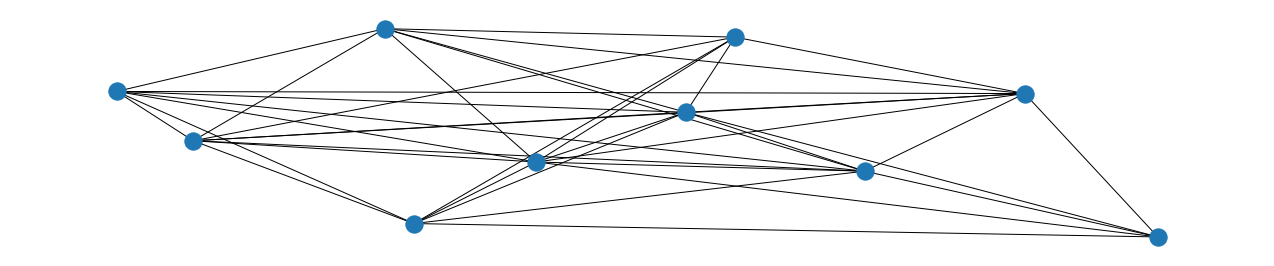

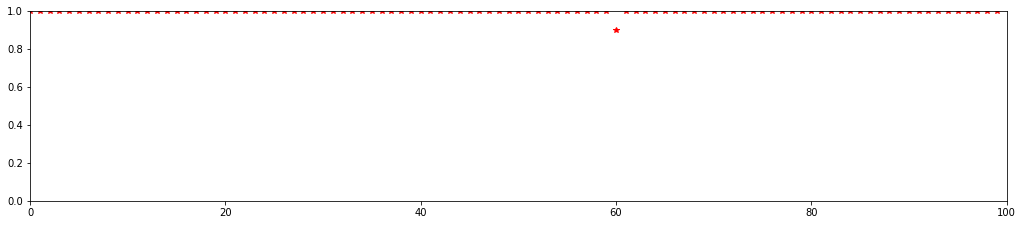

In [439]:
BoltzmannModel = BoltzmannGRN(size, gene_start_probability, weight, sparsity) 
BoltzmannGraph = BoltzmannModel.graph
nx.draw(BoltzmannGraph)
plt.show()
time, list_size = BoltzmannModel.update(size, BoltzmannGraph, 100)
BoltzmannModel.show_plot(time, list_size)

#Explore Degree Distribution

**Archieved Functions**

In [ ]:
  def add_nodes(self, G, parent, num_to_add):
    num_Nodes = G.number_of_nodes()
    nodes_to_add = []
    for n in range(1, 3):
      nodes_to_add.append(num_Nodes+n)
    for node in nodes_to_add:
      G.add_edge(parent, node)
  
    def group_duplicate_index(df):
      a = df.values
      sidx = np.lexsort(a.T)
      b = a[sidx]

      m = np.concatenate(([False], (b[1:] == b[:-1]).all(1), [False] ))
      idx = np.flatnonzero(m[1:] != m[:-1])
      I = df.index[sidx].tolist()
      return [I[i:j] for i,j in zip(idx[::2],idx[1::2]+1)]

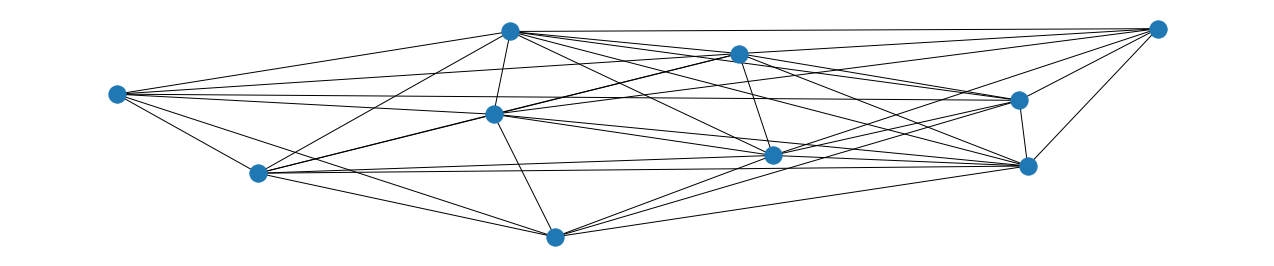

Graph with 10 nodes and 45 edges


In [301]:
G = nx.complete_graph(10)
T = nx.Graph()
T.add_node(0)
for i in range(1, 10):
  num = T.number_of_nodes()
  #print(num)
  T.add_node(i)
  toConnect = random.randint(0, num-1)
  #T.add_nodes_from([toConnect, i])
  #if random.random() >= 0.5:
  #  T.add_nodes_from([toConnect, i])
  T.add_edge(toConnect, i)
"""G.add_nodes_from([2, 3])
G.add_edge(2,3)
G.add_edge(3,2)
print(G)
print(G.edges)
print(G.has_edge(2, 3))
print(G.has_edge(3, 2))
print(G.number_of_edges())"""
D = nx.difference(G, T)
num_remove = math.ceil(len(D.edges) * Sparsity)
edgeSet = D.Edges
rmlist = []
for i in range(0, num_remove):
  rmlist.append(random.choice(edgeSet))
for item in rmlist:
  a = item[0]
  b = item[1]
  D.remove_edge(a,b)
nx.draw(D)
plt.show()
print(G)

In [291]:
intervalOver = False
      stuckCount = 0
      count = 0
      removed = []
      while (stuckCount < 400):
        intervalOver = False
        while intervalOver == False:
          edgesPairs = []
          for x, y in G.edges:
            edgesPairs.append((x, y))
          if len(edgesPairs) != 0: 
            randomEdge = random.choice(edgesPairs)
            a = randomEdge[0]
            b = randomEdge[1]
            #print(type(randomEdge))
            #print(a,b)
            G.remove_edge(a,b)
            if nx.number_connected_components(G) == 1:
              stuckCount = 0
              intervalOver = True
            else:
              G.add_edge(a,b)
              stuckCount += 1
              if stuckCount >= 400:
                intervalOver = True
              else:
                #print(stuckCount)
                intervalOver = False
          else:
            return G

IndentationError: ignored